In [567]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('nbagg')

%matplotlib inline

In [568]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Specify filename

In [569]:
filename = "drive/MyDrive/IG.asc"

### Load eyelink data

In [570]:
# read eyelink data from asc file
with open(filename, 'r') as f:
    data = f.readlines()
# extract sampling parameters
DISPLAY_COORDS = list(map(float,[x[:-1].split(' ') for x in data if 'DISPLAY_COORDS' in x][0][-2:]))
RETRACE_INTERVAL = float([x[:-1].split(' ') for x in data if 'RETRACE_INTERVAL' in x][0][-1:][0])
SAMPLE_RATE = float([x[:-1].split('\t') for x in data if 'RATE' in x and x.startswith('SAMPLES')][0][4])
# extract trial parameters
START = np.array([int(x[:-1].split('\t')[1]) for x in data if x.startswith('START')], 'int')
END = np.array([int(x[:-1].split('\t')[1]) for x in data if x.startswith('END')], 'int')
assert len(START)==len(END)
DUR = END-START
TARGET_POS = [list(map(int,x[:-1].split(' ')[4][1:-1].split(','))) for x in data if 'TARGET_POS' in x]
# isolate lines denoting eye position (those ending with ellipses)
data = [line[:-4] for line in data if line[-4:] == '...\n']
# convert list[str] to numpy matrix
data = np.genfromtxt(
    data,
    delimiter='\t',
    usecols=range(5),
    missing_values='.',
    filling_values=np.nan,
    dtype=float
)
# scale data to sampling parameters
xtrans = lambda x: 2*(x/DISPLAY_COORDS[0] - 0.5)
ytrans = lambda x: 2*(x/DISPLAY_COORDS[1] - 0.5)
data[:,1] = xtrans(data[:,1])
data[:,2] = ytrans(data[:,2])
TARGET_POS = [[xtrans(x), ytrans(y)] for x, y in TARGET_POS]
# labels
channel_label = [
    'sample',
    'x-pos (norm)',
    'y-pos (norm)',
    'pupil (raw)',
    'constant',
]

# convert to pandas dataframe
df = pd.DataFrame(data[:,:-1], columns = channel_label[:-1])
# fill-in missing samples (aligns samples to indices)
df['sample'] = df['sample'].astype('int')
new_index = pd.Index(np.arange(df['sample'].iloc[0],df['sample'].iloc[-1]), name="sample")
df = df.set_index("sample").reindex(new_index).reset_index()
# zero starting sample
FIRST_SAMPLE = df['sample'].iloc[0]
START = START - FIRST_SAMPLE
END = END - FIRST_SAMPLE
df['sample'] = df['sample']-FIRST_SAMPLE
# samples to time
channel_label[0] = 'Time (msecs)'
df[channel_label[0]] = df['sample']*1000/SAMPLE_RATE  # msecs
df = df.drop('sample', axis=1)

print(df)

        x-pos (norm)  y-pos (norm)  pupil (raw)  Time (msecs)
0           0.112871     -0.130306       1419.0           0.0
1           0.112871     -0.129935       1419.0           1.0
2           0.112871     -0.131047       1418.0           2.0
3           0.112976     -0.132345       1417.0           3.0
4           0.113184     -0.132901       1416.0           4.0
...              ...           ...          ...           ...
400744      0.623345     -0.014829       1365.0      400744.0
400745      0.623658     -0.014829       1366.0      400745.0
400746      0.624075     -0.014829       1365.0      400746.0
400747      0.624179     -0.014829       1365.0      400747.0
400748      0.624075     -0.014458       1365.0      400748.0

[400749 rows x 4 columns]


### Examine channel data

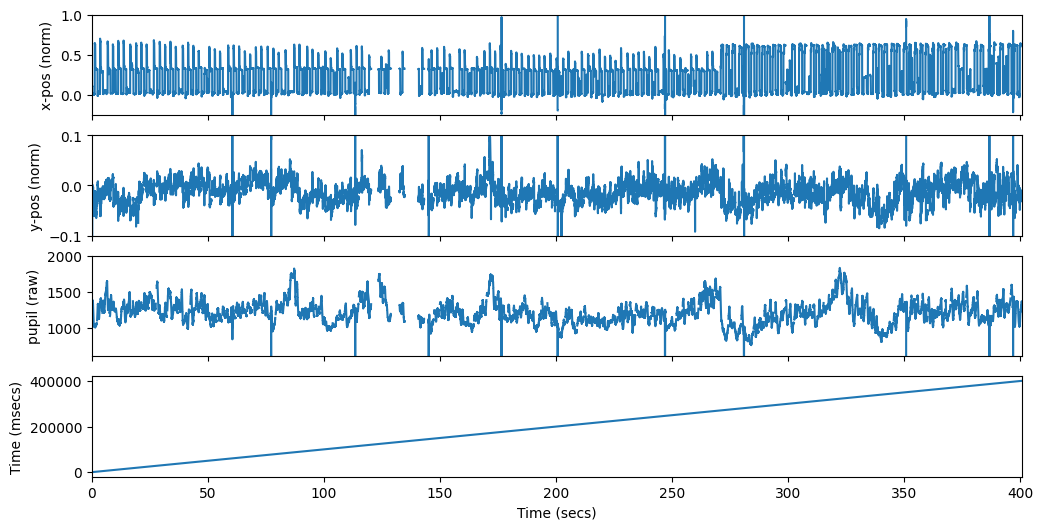

In [571]:
time_secs = df['Time (msecs)']/1000
fig, axs = plt.subplots(len(df.columns), figsize=(12, 6), sharex=True)
for k, colname in enumerate(df.columns):
    axs[k].plot(time_secs, df[colname])
    axs[k].set_ylabel(colname)
axs[0].set_xlim(time_secs.iloc[0], time_secs.iloc[-1])

axs[0].set_ylim(-0.25, 1.0)
axs[1].set_ylim(-0.1, 0.1)
axs[2].set_ylim(600, 2000)
axs[3].set_xlabel('Time (secs)')
fig.show()

### xy-trace

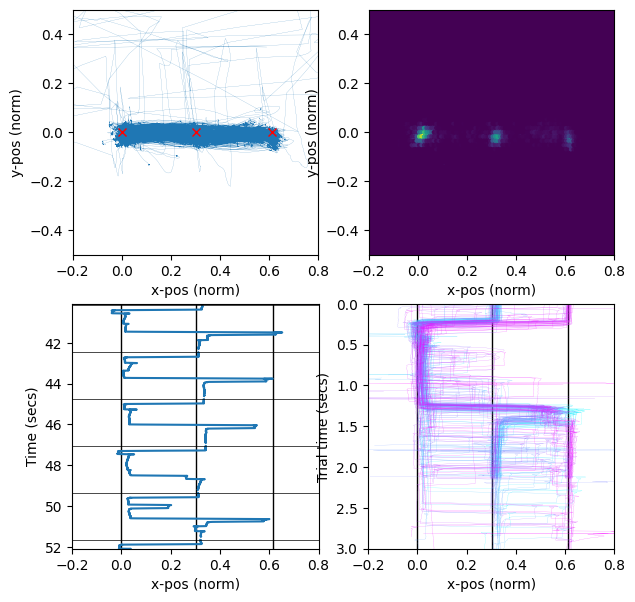

In [572]:
chx, chy = 'x-pos (norm)', 'y-pos (norm)'  # x, y

fig, axs = plt.subplot_mosaic(
    [['b','c'], ['a','d']],
    figsize=(7, 7),
)

# temporal segment
for x, y in np.unique(np.array(TARGET_POS), axis=0):
  axs['a'].plot(np.array([x, x]), [time_secs.iloc[0], time_secs.iloc[-1]], 'k-', linewidth=1)
axs['a'].plot(df[chx], time_secs)
for start, end in zip(START, END):
  axs['a'].plot(np.array([-1, 1]), np.array([start, start])/SAMPLE_RATE, 'k-', linewidth=0.5)
axs['a'].set_xlim(-0.2, 0.8)
axs['a'].set_xlabel(chx)
axs['a'].set_ylabel('Time (secs)')
axs['a'].set_ylim(
    time_secs.iloc[round(0.100*len(time_secs))],
    time_secs.iloc[round(0.130*len(time_secs))],
)
axs['a'].invert_yaxis()

# xy-trace
axs['b'].plot(df[chx], df[chy], linewidth=0.1)
for x, y in np.unique(np.array(TARGET_POS), axis=0):
  axs['b'].plot(x, y, 'rx')
axs['b'].set_aspect('equal', 'box')
axs['b'].set_xlim(-0.2, 0.8)
axs['b'].set_ylim(-0.5, 0.5)
axs['b'].set_xlabel(chx)
axs['b'].set_ylabel(chy)

# spatial histogram
axs['c'].hexbin(
    df[chx],
    df[chy],
    extent=(-0.2, 0.8, -0.5, 0.5),
)
axs['c'].set_aspect('equal', 'box')
axs['c'].set_xlim(-0.2, 0.8)
axs['c'].set_ylim(-0.5, 0.5)
axs['c'].set_xlabel(chx)
axs['c'].set_ylabel(chy)

# stack trials
for x, y in np.unique(np.array(TARGET_POS), axis=0):
  axs['d'].plot(np.array([x, x]), np.array([0.0, 3.0]), 'k-', linewidth=1)
viridis = matplotlib.colormaps['cool']
for index, (start, end) in enumerate(zip(START, END)):
  axs['d'].plot(
      df[chx].iloc[start:end],
      time_secs.iloc[start:end]-time_secs.iloc[start],
      '-',
      linewidth=0.1,
      color=viridis(index/(len(START)-1)),
  )
axs['d'].set_ylabel('Trial time (secs)')
axs['d'].set_xlabel(chx)
axs['d'].set_xlim(-0.2, 0.8)
axs['d'].set_ylim(0, 3)
axs['d'].invert_yaxis()

fig.show()